## 02: Data Preparation Subprime

1. Here we construct our dataset for use in the experiment.

In [1]:
# import required libraries
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import random
import libs.utils as utils
import libs.bounding_box as bounding_box
import libs.patch_tools as patch_tools
import libs.data_prep as data_prep
import libs.train_test_split as tts
import libs.importing as importing
import libs.render as render
import libs.stats as stats
import libs.patch_tools as patch_tools
from importlib import reload


# set the random seed for we always get the same results (for now)
random.seed(42)


In [3]:
# GENERATE DATASET ID
exp_id = utils.short_id()
# use same data
exp_id = 'a2aaceaa'
print('ID: {}'.format(exp_id))

ID: a2aaceaa


In [4]:
# COPY DATA and SETUP EXPERIMENT
base_dir = '../source_dataset/all_v1'
data_prep.setup_experiment(base_dir, exp_id)

In [19]:
# 2-CLASS PROBLEM : Benign v. Papilloma

# SETUP : GET ALL CONTOURS
roi_df = pd.read_csv(os.path.join(exp_id, 'contours.csv'))
roi_2class = roi_df.copy()

# merge dysplasias and carcinomas
#roi_2class.loc[roi_2class['label'] == 4, 'label'] = 3

train2bp_df, test2bp_df, val2bp_df = tts.train_test_validation_split(roi_2class, classes=[1,2,3,4], samples=2)

# SAVE : save the results
train2bp_df.to_csv(os.path.join(exp_id, 'contours_train.csv'), index=False)
test2bp_df.to_csv(os.path.join(exp_id, 'contours_test.csv'), index=False)
val2bp_df.to_csv(os.path.join(exp_id, 'contours_val.csv'), index=False)

n: 97
distribution: [1 2 3 4] [30 20 13 34]
classes: [1 2 3 4], samples_per_class: 2
train-n: 81
test-n: 8
val-n: 8


In [18]:
# OR IF we've already run this notebook before we can just load the data
train2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_train.csv'))
test2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_test.csv'))
val2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_val.csv'))

In [20]:
# LOG : show all the contours we dumped and those we are using
#       these are logged at: 
#       [dumped] ./exp_id/log/eleminated_contours
#       [kept]   ./exp_id/log/experiment_contours
data_prep.show_contours_for_experiment(exp_id, roi_df, roi_2class)

total contours: 97
eliminated contours: 0
kept contours: 97


Empty DataFrame
Columns: [image_id, id, name, label]
Index: []

In [21]:
# TRAIN : data setup
#       : creates a directory ./exp_id/train/  where all the images and contours for training are stored
#       : creates a directory ./exp_id/train/log/info, where the contours and labels for the training set are stored as images for debugging purposes. 
train_df  = pd.read_csv(os.path.join(exp_id, 'contours_train.csv'))
data_prep.setup_component(exp_id, train_df, 'train')
data_prep.log_component_info(os.path.join(exp_id, 'train'))

In [22]:
# TEST : data setup
#       : creates a directory ./exp_id/test/  where all the images and contours for test data are stored
#       : creates a directory ./exp_id/test/log/info, where the contours and labels for the test set are stored as images for debugging purposes.
test_df = pd.read_csv(os.path.join(exp_id, 'contours_test.csv'))
data_prep.setup_component(exp_id, test_df, 'test')
data_prep.log_component_info(os.path.join(exp_id, 'test'))

In [23]:
# VALIDATION : data setup
#       : creates a directory ./exp_id/val/  where all the images and contours for validation data are stored
#       : creates a directory ./exp_id/val/log/info, where the contours and labels for the validation set are stored as images for debugging purposes.
val_df = pd.read_csv(os.path.join(exp_id, 'contours_val.csv'))
data_prep.setup_component(exp_id, val_df, 'val')
data_prep.log_component_info(os.path.join(exp_id, 'val'))

In [24]:
# GENERATE PATCHES : training data
#                    logs information to ./exp_id/train/log/setup_patches, where it shows patches on the image before and after removal

# threshold : the percentage a patch needs to overlap with the contour polygon in order to not be discarded
# patch_overlap : the shift size, should be a value which generates a factor of 64 for instance 0.5*64 = 32, or 0.25 * 64 = 16, etc.
train_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'train'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

# inspect the structure of our patches.csv file
display(train_patches_df.head())

# see how many training patches we have 
print('count: {}'.format(len(train_patches_df)))

image_id contour_id  patch_id    patch_name    x    y label_id
0  hgv-44a1f2e3   2dd43905  b71ba377  b71ba377.jpg  762  674        4
1  hgv-44a1f2e3   2dd43905  4226541c  4226541c.jpg  794  674        4
2  hgv-44a1f2e3   2dd43905  aa3ddc27  aa3ddc27.jpg  826  674        4
3  hgv-44a1f2e3   2dd43905  dede2457  dede2457.jpg  858  674        4
4  hgv-44a1f2e3   2dd43905  e3bfd066  e3bfd066.jpg  890  674        4

count: 4443


In [25]:
# GENERATE PATCHES : test data
#                    logs information to ./exp_id/test/log/setup_patches, where it shows patches on the image before and after removal
test_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'test'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

display(test_patches_df.head())
print('count: {}'.format(len(test_patches_df)))

image_id contour_id  patch_id    patch_name     x    y label_id
0  hgv-8528141b   0f887b7a  9cb628f6  9cb628f6.jpg  1131  486        2
1  hgv-8528141b   0f887b7a  bd214841  bd214841.jpg  1163  486        2
2  hgv-8528141b   0f887b7a  9f6fc7b5  9f6fc7b5.jpg  1195  486        2
3  hgv-8528141b   0f887b7a  645a12d4  645a12d4.jpg  1099  518        2
4  hgv-8528141b   0f887b7a  1283e99a  1283e99a.jpg  1131  518        2

count: 419


In [26]:
# GENERATE PATCHES : validation data
#                    logs information to ./exp_id/val/log/setup_patches, where it shows patches on the image before and after removal
val_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'val'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

display(val_patches_df.head())
print('count: {}'.format(len(val_patches_df)))

image_id contour_id  patch_id    patch_name     x    y label_id
0  hgv-99fc12a1   93d2c382  8d13aedf  8d13aedf.jpg  1019  643        2
1  hgv-99fc12a1   93d2c382  6c1a7d6c  6c1a7d6c.jpg   987  675        2
2  hgv-99fc12a1   93d2c382  49882b23  49882b23.jpg  1019  675        2
3  hgv-99fc12a1   93d2c382  87c925e1  87c925e1.jpg   987  707        2
4  hgv-99fc12a1   93d2c382  cef67d9b  cef67d9b.jpg  1019  707        2

count: 242


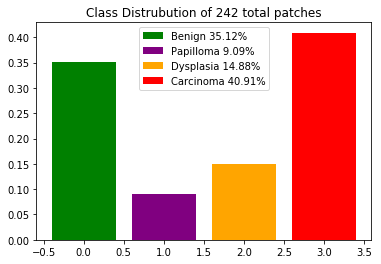

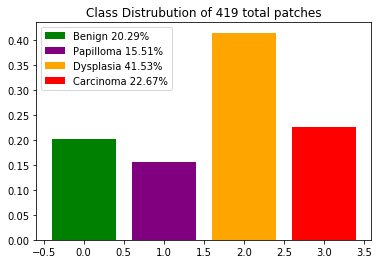

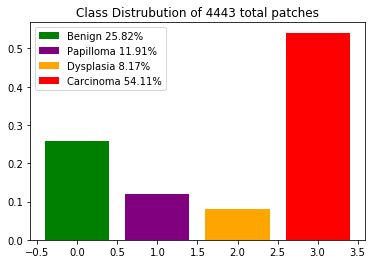

In [27]:
# BEFORE FILTERING PATCHES LOOK AT PATCH DISTRIBUTION
stats.plot_label_distribution(val_patches_df, labels=[1,2,3,4], label_key='label_id')
stats.plot_label_distribution(test_patches_df, labels=[1,2,3,4], label_key='label_id')
stats.plot_label_distribution(train_patches_df, labels=[1,2,3,4], label_key='label_id')

In [29]:
# FILTER PATCHES : some patches have way too much light or are just bad quality
#                  here we filter out patches which are so specular they contain very little information
#                  see: filtered patches are drawn onto the image at : ./exp_id/{train,test,val}/log/filter_highlight_patches - useful for debugging

train_dir = os.path.join(exp_id, 'train')
test_dir = os.path.join(exp_id, 'test')
val_dir = os.path.join(exp_id, 'val')

data_prep.filter_highlight_patches_for(train_dir, patch_size = 64, threshold=0.4)
data_prep.filter_highlight_patches_for(test_dir, patch_size = 64, threshold=0.4)
data_prep.filter_highlight_patches_for(val_dir, patch_size = 64, threshold=0.4)


bad patches: 41
before: 4443
cleaned: 4402
bad patches: 0
before: 419
cleaned: 419
bad patches: 3
before: 242
cleaned: 239


image_id contour_id  patch_id    patch_name     x    y  label_id
0    hgv-99fc12a1   93d2c382  8d13aedf  8d13aedf.jpg  1019  643         2
1    hgv-99fc12a1   93d2c382  6c1a7d6c  6c1a7d6c.jpg   987  675         2
2    hgv-99fc12a1   93d2c382  49882b23  49882b23.jpg  1019  675         2
3    hgv-99fc12a1   93d2c382  87c925e1  87c925e1.jpg   987  707         2
4    hgv-99fc12a1   93d2c382  cef67d9b  cef67d9b.jpg  1019  707         2
5    hgv-99fc12a1   93d2c382  5386695a  5386695a.jpg  1051  707         2
6    hgv-2cdb69f6   8206157b  2ffa497b  2ffa497b.jpg   738  168         3
7    hgv-2cdb69f6   8206157b  777c992d  777c992d.jpg   770  168         3
8    hgv-2cdb69f6   8206157b  28bdcac0  28bdcac0.jpg   802  168         3
9    hgv-2cdb69f6   8206157b  372718dd  372718dd.jpg   738  200         3
12   hgv-2cdb69f6   8206157b  0bc4fc2a  0bc4fc2a.jpg   834  200         3
13   hgv-2cdb69f6   8206157b  f7b352b5  f7b352b5.jpg   738  232         3
14   hgv-2cdb69f6   8206157b  f3ae62c1  f3ae62c1.jpg   770  232         3
16   hgv-2cdb69f6   8206157b  38ac351a  38ac351a.jpg   834  232         3
17   hgv-2cdb69f6   8206157b  292bc594  292bc594.jpg   770  264         3
18   hgv-2cdb69f6   8206157b  0de591b9  0de591b9.jpg   802  264         3
19   hgv-2cdb69f6   8206157b  269aa3f5  269aa3f5.jpg   834  264         3
20   hgv-2cdb69f6   8206157b  1514a3ef  1514a3ef.jpg   866  264         3
21   hgv-2cdb69f6   8206157b  c8e55ecb  c8e55ecb.jpg   802  296         3
22   hgv-2cdb69f6   8206157b  bae14e33  bae14e33.jpg   834  296         3
23   hgv-2cdb69f6   8206157b  e493463a  e493463a.jpg   866  296         3
24   hgv-2cdb69f6   8206157b  420e2ad8  420e2ad8.jpg   834  328         3
25   hgv-2cdb69f6   8206157b  b003d550  b003d550.jpg   866  328         3
26   hgv-2cdb69f6   8206157b  2d41c8d4  2d41c8d4.jpg   898  328         3
27   hgv-2cdb69f6   8206157b  0379fa95  0379fa95.jpg   866  360         3
28   hgv-2cdb69f6   8206157b  e5fe9936  e5fe9936.jpg   898  360         3
29   hgv-2cdb69f6   8206157b  7bd3879a  7bd3879a.jpg   898  392         3
30   hgv-dffcce57   162054c8  4827222b  4827222b.jpg  1335  522         4
31   hgv-dffcce57   162054c8  e4c49144  e4c49144.jpg  1303  554         4
32   hgv-dffcce57   162054c8  0e29a788  0e29a788.jpg  1335  554         4
..            ...        ...       ...           ...   ...  ...       ...
212  odi-1767f1a2   f92bbc3e  d2caa167  d2caa167.jpg   175  428         1
213  odi-1767f1a2   f92bbc3e  bbdf152a  bbdf152a.jpg   207  428         1
214  odi-28084697   1b95bdd9  79132461  79132461.jpg   448  362         3
215  odi-28084697   1b95bdd9  51052946  51052946.jpg   416  394         3
216  odi-28084697   1b95bdd9  d9fb1228  d9fb1228.jpg   448  394         3
217  odi-28084697   1b95bdd9  254c5f0c  254c5f0c.jpg   416  426         3
218  odi-28084697   1b95bdd9  4194d1d4  4194d1d4.jpg   448  426         3
219  odi-28084697   1b95bdd9  dc34d8de  dc34d8de.jpg   416  458         3
220  odi-28084697   1b95bdd9  4ccb8a68  4ccb8a68.jpg   448  458         3
221  odi-28084697   1b95bdd9  63bc40ee  63bc40ee.jpg   416  490         3
222  odi-28084697   1b95bdd9  3926d522  3926d522.jpg   448  490         3
223  odi-28084697   1b95bdd9  6a82cbb4  6a82cbb4.jpg   416  522         3
224  odi-28084697   1b95bdd9  5d691402  5d691402.jpg   448  522         3
225  odi-28084697   1b95bdd9  ee054e0f  ee054e0f.jpg   448  554         3
226  odi-bf734aed   a3bd3fb8  dfbe5c07  dfbe5c07.jpg   315   36         2
227  odi-bf734aed   a3bd3fb8  87fc8b9a  87fc8b9a.jpg   347   36         2
228  odi-bf734aed   a3bd3fb8  7199d874  7199d874.jpg   379   36         2
229  odi-bf734aed   a3bd3fb8  f4067a72  f4067a72.jpg   315   68         2
230  odi-bf734aed   a3bd3fb8  07acbc1b  07acbc1b.jpg   347   68         2
231  odi-bf734aed   a3bd3fb8  288582fd  288582fd.jpg   379   68         2
232  odi-bf734aed   a3bd3fb8  95335a91  95335a91.jpg   315  100         2
233  odi-bf734aed   a3bd3fb8  c370ddd3  c370ddd3.jpg   347  100         2
234  odi-bf73

In [30]:
## READ PATCHES : check to ensure we are ready to go to the next step
trainp_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned.csv'), index_col=False)
testp_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned.csv'), index_col=False)
valp_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned.csv'), index_col=False)

train_pdr = importing.PatchDataReader(os.path.join(train_dir, 'patches'), trainp_df)
test_pdr = importing.PatchDataReader(os.path.join(test_dir, 'patches'), testp_df)
val_pdr = importing.PatchDataReader(os.path.join(val_dir, 'patches'), valp_df)

train_img, train_labels = train_pdr.read_data()
test_img, test_labels = test_pdr.read_data()
val_img, val_labels = val_pdr.read_data()

display('train images: {}'.format(len(train_img)))
display('train labels: {}'.format(len(train_labels)))
display('test images: {}'.format(len(test_img)))
display('test labels: {}'.format(len(test_labels)))
display('val images: {}'.format(len(val_labels)))
display('val labels: {}'.format(len(val_img)))


'train images: 4402'

'train labels: 4402'

'test images: 419'

'test labels: 419'

'val images: 239'

'val labels: 239'

In [31]:
# CREATE SHUFFLED DATA

## READ PATCHES : check to ensure we are ready to go to the next step
trainp_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned.csv'), index_col=False)
testp_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned.csv'), index_col=False)
valp_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned.csv'), index_col=False)

idxs = data_prep.shuffle_indices(len(trainp_df))
shuffled_train_df = trainp_df.loc[idxs].reset_index(drop=True)
shuffled_train_df.to_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'), index=False)

idxs = data_prep.shuffle_indices(len(testp_df))
shuffled_test_df = testp_df.loc[idxs].reset_index(drop=True)
shuffled_test_df.to_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'), index=False)

idxs = data_prep.shuffle_indices(len(valp_df))
shuffled_val_df = valp_df.loc[idxs].reset_index(drop=True)
shuffled_val_df.to_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'), index=False)



In [32]:
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_pdr)
data_prep.log_patch_data_reader(test_dir, test_pdr)
data_prep.log_patch_data_reader(val_dir, val_pdr)